In [65]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

np.random.seed(1)
tf.set_random_seed(1)

# DQN+MLP with one hidden layer
class MLP1():
    def __init__(self,
                n_actions, 
                n_features,
                learning_rate=0.01,
                reward_decay=0.9,
                e_greedy=0.9,
                replace_target_iter=300,
                memory_size=500
                ):
        self.n_actions= n_actions
        self.n_features= n_features
        self.lr= learning_rate
        self.gamma= reward_decay
        self.epsilon_max= e_greedy
        self.replace_target_iter= replace_target_iter
        self.memory_size= memory_size
        self.epsilon= e_greedy
        
        # Total learning step
        self.learn_step_counter= 0
        
        # Initialize zero-memory [s, a, r, s_]
        self.memory= np.zeros((self.memory_size, n_features*2+2))
        
        # Consist of [target_net, evaluate_net]
        self.nInternalUnits=64
        self._build_net(self.nInternalUnits)
        
        self.sess= tf.Session()
        
        #with tf.compat.v1.Session() as sess:
            
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.replace_target_op)
        
        self.cost_his=[]
        
        
    def _build_net(self, nInternalUnits):
        # Build evaluate net
        #tf.compat.v1.disable_eager_execution()
        self.s= tf.placeholder(tf.float32, [None, self.n_features])# Input
        self.q_target= tf.placeholder(tf.float32, [None, self.n_actions])# for calculating loss
        
        
        self.w1_eval= tf.Variable(tf.random.normal([self.n_features, nInternalUnits], mean=0.0, stddev=0.3)) 
        self.b1_eval= tf.Variable(tf.random.normal([1, nInternalUnits], mean=0, stddev=0.3))
        self.l1_eval= tf.nn.tanh(tf.matmul(self.s, self.w1_eval)+self.b1_eval)
        
        self.w2_eval= tf.Variable(tf.random.normal([nInternalUnits, nInternalUnits], mean=0.0, stddev=0.3))
        self.b2_eval= tf.Variable(tf.random.normal([1, nInternalUnits], mean=0.0, stddev=0.3))
        self.l2_eval=tf.matmul(self.l1_eval, self.w2_eval)+self.b2_eval
        
        self.w3_eval = tf.Variable(tf.random_normal([nInternalUnits, nInternalUnits], mean=0.0, stddev=0.3))
        self.b3_eval = tf.Variable(tf.random_normal([1, nInternalUnits], mean=0.0, stddev=0.3))
        self.l3_eval = tf.matmul(self.l2_eval, self.w3_eval) + self.b3_eval
        
        self.w4_eval = tf.Variable(tf.random_normal([nInternalUnits, self.n_actions], mean=0.0, stddev=0.3))
        self.b4_eval = tf.Variable(tf.random_normal([1, self.n_actions], mean=0.0, stddev=0.3))
        self.q_eval = tf.matmul(self.l3_eval, self.w4_eval) + self.b4_eval
        
        
        
        
        self.loss= tf.reduce_mean(tf.math.squared_difference(self.q_target, self.q_eval))
        self._train_op= tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        
        # Build target net
        self.s_= tf.compat.v1.placeholder(tf.float32, [None, self.n_features])# Input
        
        self.w1_target= tf.Variable(tf.random.normal([self.n_features, nInternalUnits], mean=0.0, stddev=0.3))
        self.b1_target= tf.Variable(tf.random.normal([1, nInternalUnits], mean=0, stddev=0.3))
        self.l1_target= tf.nn.tanh(tf.matmul(self.s_, self.w1_target)+self.b1_target)
        
        self.w2_target= tf.Variable(tf.random.normal([nInternalUnits, nInternalUnits], mean=0.0, stddev=0.3))
        self.b2_target= tf.Variable(tf.random.normal([1, nInternalUnits], mean=0.0, stddev=0.3))
        self.l2_target= tf.matmul(self.l1_target, self.w2_target)+self.b2_target
        
        self.w3_target = tf.Variable(tf.random_normal([nInternalUnits, nInternalUnits], mean=0.0, stddev=0.3))
        self.b3_target = tf.Variable(tf.random_normal([1, nInternalUnits], mean=0.0, stddev=0.3))
        self.l3_target = tf.matmul(self.l2_target, self.w3_target)+self.b3_target
        
        self.w4_target = tf.Variable(tf.random_normal([nInternalUnits, self.n_actions], mean=0.0, stddev=0.3))
        self.b4_target = tf.Variable(tf.random_normal([1, self.n_actions], mean=0.0, stddev=0.3))
        self.q_next = tf.matmul(self.l3_target, self.w4_target) + self.b4_target
        
        
        
        
        
        self.replace_target_op= [tf.compat.v1.assign(self.w1_target, self.w1_eval), tf.compat.v1.assign(self.b1_target, self.b1_eval),
                                tf.compat.v1.assign(self.w2_target, self.w2_eval), tf.compat.v1.assign(self.b2_target, self.b2_eval)
                                
                                ]
        
        
    def store_transition(self, s, a, r, s_):
        
        if not hasattr (self, 'memory_counter'):
            self.memory_counter=0
        
        
        transition= np.hstack((s, [a, r], s_))
        
        #Replace the old memory with new memory
        index= self.memory_counter % self.memory_size
        self.memory[index, :]= transition
        
        self.memory_counter+=1
        
    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation= observation[np.newaxis, :]
        
        if np.random.uniform()<self.epsilon:
            action= np.random.randint(0, self.n_actions)
        else:
            # Forward feed the observation and get the q_value for every actions
            actions_value= self.sess.run(self.q_eval, feed_dict= {self.s: observation})
            action= np.argmax(actions_value)
            
        return action
    
    def learn(self):
        
        batch_memory= self.memory
        with tf.compat.v1.Session() as sess:
            
            q_next, q_eval= self.sess.run(
                [self.q_next, self.q_eval],
                feed_dict= {
                    self.s_: batch_memory[:,-self.n_features:],# fixed params
                    self.s: batch_memory[:, :self.n_features], #newest params
                })
        # Change the q_target with q_eval's actions
        q_target= q_eval.copy()
        
        eval_act_index= batch_memory[:, self.n_features].astype(int)
        reward= batch_memory[:, self.n_features+1]
        
        next_q_value= self.gamma*np.max(q_next, axis=1)
        
        
        for index in range(len(eval_act_index)):
            q_target[index, eval_act_index[index]]= reward[index]+next_q_value[index]
            
            
        # Train eval network
        with tf.compat.v1.Session() as sess:
            
            _, self.cost= self.sess.run([self._train_op, self.loss], 
                                       feed_dict= {self.s: batch_memory[:, :self.n_features], self.q_target:q_target})
        
        self.cost_his.append(self.cost)
        
        # Replace target parameters
        if self.learn_step_counter % self.replace_target_iter==0:
            self.sess.run(self.replace_target_op)
        
        self.learn_step_counter+=1

In [66]:
class DSA_Markov():
    def __init__(self,
                n_channel,
                n_su,
                sense_error_prob_max=0.2,
                punish_interfer_PU=-2):
        self.n_channel= n_channel # The number of channels
        self.n_su= n_su # then number of secondary users
        
        # Initialize the Markov channels
        self._build_Markov_channel()
        
        # Initialize the locations of SUs and PUs
        self._build_location()
        
        # Set the noise(Mw)
        self.Noise= 1*np.float_power(10,-8)
        # Set the carrier frequency (5 Ghz)
        self.fc= 5
        # Set the k in channel gain
        self.k= 8
        # Set the power of PU and SU(mw)
        self.SU_power= 20
        self.PU_power= 40
        
        # Initialize SINR(no consideration of interference of SUs)
        self.render_SINR()
        
        self.n_actions= n_channel+1 # The action space size
        self.n_features= n_channel # The sensing result space
        
        self.sense_error_prob_max= sense_error_prob_max
        self.sense_error_prob= np.random.uniform(0, self.sense_error_prob_max, size=(self.n_su, self.n_channel))
        
        # The punishment for interferring PUs
        self.punish_interfer_PU= punish_interfer_PU
        
    def _build_Markov_channel(self):
        # Initialize channel state(uniform distribution)
        # 1: Inactive Pu
        # 0: Active Pu
        
        self.channel_state= np.random.choice(2, self.n_channel)
        
        # Initialize the transition probability of independent channels
        self.stayGood_prob= np.random.uniform(0.7, 1, self.n_channel)
        self.stayBad_prob= np.random.uniform(0, 0.3, self.n_channel)
        self.goodToBad_prob= 1- self.stayGood_prob
        self.badToGood_prob= 1- self.stayBad_prob
        
    def _build_location(self):
        # Initialize the location of PUs
        self.PU_TX_x= np.random.uniform(0, 150, self.n_channel)
        self.PU_TX_y= np.random.uniform(0, 150, self.n_channel)
        self.PU_RX_x= np.random.uniform(0, 150, self.n_channel)
        self.PU_RX_y= np.random.uniform(0, 150, self.n_channel)
        
        
        # Initialize the location of SUs transmitters
        self.SU_TX_x= np.random.uniform(0+40, 150-40, self.n_su)
        self.SU_TX_y= np.random.uniform(0+40, 150-40, self.n_su)
        
        # Initialize the distance between SU's transmitter and receiver
        self.SU_d= np.random.uniform(20, 40, self.n_su)
        
        # Initialize the location of SUs receivers
        SU_theda= 2*np.pi*np.random.uniform(0, 1, self.n_su)
        SU_dx= self.SU_d*np.cos(SU_theda)
        SU_dy= self.SU_d*np.sin(SU_theda)
        self.SU_RX_x= self.SU_TX_x+ SU_dx
        self.SU_RX_y= self.SU_TX_y+ SU_dy
        
        # Compute the distance between PU_Tx and SU_Rx
        self.SU_RX_PU_TX_d= np.zeros((self.n_su, self.n_channel))
        for k in range(self.n_su):
            for l in range(self.n_channel):
                self.SU_RX_PU_TX_d[k][l]= np.sqrt(
                np.float_power((self.SU_RX_x[k]-self.PU_TX_x[l]),2)+
                    np.float_power((self.SU_RX_y[k]-self.PU_TX_y[l]), 2)
                )
        
        # Compute the distance between SU_TX and SU_RX
        self.SU_RX_SU_TX_d= np.zeros((self.n_su, self.n_su))
        for k1 in range(self.n_su):
            for k2 in range(self.n_su):
                self.SU_RX_SU_TX_d[k1][k2]= np.sqrt(
                np.float_power(self.SU_RX_x[k1]-self.SU_TX_x[k2], 2)+
                    np.float_power(self.SU_RX_y[k1]-self.SU_TX_y[k2], 2)
                )
        # Plot the locations
        plt.plot(self.PU_TX_x, self.PU_TX_y,'ro',label='PU_TX' )
        plt.plot(self.PU_RX_x, self.PU_RX_y,'rx' ,label='PU_RX')
        plt.plot(self.SU_TX_x, self.SU_TX_y,'bs',label='SU_TX')
        plt.plot(self.SU_RX_x, self.SU_RX_y,'b^',label='SU_RX')
        plt.legend(loc='lower right')
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()
        
        
    def store_action(self, action):
        self.action= action
        
    def sense(self):
        tmp_dice= np.random.uniform(0, 1, size=(self.n_su, self.n_channel))
        error_index= tmp_dice< self.sense_error_prob # True: sensing error happens, False: sensing is correct
        
        # Get the sensing result
        self.sensing_result= self.channel_state*(1-error_index)+ (1-self.channel_state)*error_index
        return self.sensing_result

    def access(self, action):
        # action[0 - n_channel-1]: 
        # action n_channel:
        self.success=0
        self.fail_PU=0
        self.fail_collision=0
        
        self.reward= np.zeros(self.n_su)
        
            # To check the number of same actions
        def eqlen(a, b):
            i=0
            for j in range(len(a)):
                if a[j]==b:
                    i=i+1
            return i
        #Calculate the interference of SUs
        Interference_SU=0
        SU_sigma2= np.float_power(10, -((41+22.7*np.log10(self.SU_RX_SU_TX_d)+20*np.log10(self.fc/5))/10))
        
        for k in range(self.n_su):
            SU_sigma2[k][k]=0
            
        for k in range(self.n_su):
            if (action[k]==self.n_channel): # Not choosing any channel
                self.reward[k]=0
            else: 
                for q in range(self.n_su):
                    if (action[q]==action[k]):
                        Interference_SU= Interference_SU+ SU_sigma2[k][q]*self.SU_power
                SINR= self.H2[k, action[k]]*self.SU_power/(Interference_SU+self.Interference_PU[k, action[k]]+self.Noise)
                self.reward[k]= np.log2(1+SINR)
                
                if (self.channel_state[action[k]]==1):
                    if (len(np.where(action==action[k])[0])==1):
                    
                    #if eqlen(action, action[k])==1:
                        #Successful transmission
                        self.success=self.success+1
                    else:
                        #Collision with SU
                        self.fail_collision=self.fail_collision+1
                        
                else:
                    #collision with PU
                    self.fail_PU=self.fail_PU+1
                    self.reward[k]= self.punish_interfer_PU
                    if (len(np.where(action==action[k])[0])> 1):
                    #if eqlen(action, action[k])>1:
                        #Collision with Su
                        self.fail_collision=self.fail_collision+1
        return self.reward
                
                
    def render(self):
        # The probability of staying in current state in next time-slot
        stay_prob= self.channel_state*self.stayGood_prob + (1-self.channel_state)*self.stayBad_prob
        tmp_dice= np.random.uniform(0, 1, self.n_channel)
        stay_index= tmp_dice<stay_prob
        self.channel_state= self.channel_state*stay_index+(1-self.channel_state)*(1-stay_index)
        
        
        
    def render_SINR(self):
        # Update the SINR
        
        # Calculate the channel gain
        SU_d= copy.deepcopy(np.reshape(self.SU_d, (-1, 1)))
        for n in range(self.n_channel-1):
            SU_d= np.hstack((SU_d, np.reshape(self.SU_d, (-1, 1))))
            
        SU_sigma2= np.float_power(10, -((41+22.7*np.log10(SU_d)+ 20*np.log10(self.fc/5))/10))
        CN_real= np.random.normal(0, 1, size=(self.n_su, self.n_channel))
        CN_imag= np.random.normal(0, 1, size=(self.n_su, self.n_channel))
        theda= np.random.uniform(0, 1, size=(self.n_su, self.n_channel))
        H= np.sqrt(self.k/(self.k+1)*SU_sigma2)*np.exp(1j*2*np.pi*theda)+np.sqrt(1/(self.k+1)*SU_sigma2/2)*(CN_real+1j*CN_imag)
        self.H2= np.float_power(np.absolute(H), 2)
        
        # Calculate the interference of PUs
        PU_sigma2= np.float_power(10, -((41+22.7*np.log10(self.SU_RX_PU_TX_d)+ 20*np.log10(self.fc/5))/10))
        channel_state= np.array([self.channel_state for k in range(self.n_su) ])
        self.Interference_PU= self.PU_power*PU_sigma2*(1-channel_state)
        
        self.SINR= self.H2*self.SU_power/(self.Interference_PU+self.Noise)

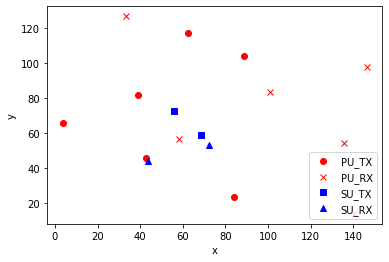

Training time=2000;  success=1330;  fail_PU=252;  fail_collision=250
Overall reward 3.9383
Training time=4000;  success=1192;  fail_PU=291;  fail_collision=308
Overall reward 3.4633
Training time=6000;  success=1286;  fail_PU=285;  fail_collision=268
Overall reward 3.7557
Training time=8000;  success=1276;  fail_PU=272;  fail_collision=310
Overall reward 3.7450
Training time=10000;  success=1298;  fail_PU=309;  fail_collision=242
Overall reward 3.7602
Training time=12000;  success=1356;  fail_PU=234;  fail_collision=240
Overall reward 4.0305
Training time=14000;  success=1365;  fail_PU=203;  fail_collision=271
Overall reward 4.0985
Training time=16000;  success=1291;  fail_PU=324;  fail_collision=239
Overall reward 3.7442
Training time=18000;  success=1279;  fail_PU=296;  fail_collision=242
Overall reward 3.7350
Training time=20000;  success=1328;  fail_PU=251;  fail_collision=246
Overall reward 3.9257
Training time=22000;  success=1237;  fail_PU=210;  fail_collision=345
Overall reward

Training time=182000;  success=1933;  fail_PU=67;  fail_collision=0
Overall reward 6.0020
Training time=184000;  success=1936;  fail_PU=63;  fail_collision=0
Overall reward 6.0139
Training time=186000;  success=1938;  fail_PU=62;  fail_collision=0
Overall reward 6.0252
Training time=188000;  success=1935;  fail_PU=64;  fail_collision=0
Overall reward 6.0104
Training time=190000;  success=1933;  fail_PU=67;  fail_collision=0
Overall reward 6.0191
Training time=192000;  success=1938;  fail_PU=62;  fail_collision=0
Overall reward 6.0310
Training time=194000;  success=1937;  fail_PU=62;  fail_collision=0
Overall reward 6.0195
Training time=196000;  success=1937;  fail_PU=62;  fail_collision=0
Overall reward 6.0010
Training time=198000;  success=1931;  fail_PU=69;  fail_collision=0
Overall reward 5.9870
Epsilon updated to 0.0
Training time=200000;  success=1932;  fail_PU=68;  fail_collision=0
Overall reward 5.9884
Training time=202000;  success=1940;  fail_PU=59;  fail_collision=0
Overall r

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import copy
if __name__=="__main__":
    random_seed= 3
    np.random.seed(random_seed)
    
    # Initialize the environment
    n_channel=6
    n_su=2
    env=DSA_Markov(n_channel, n_su)
    env_copy= copy.deepcopy(env)
    
    # Training parameters
    if n_channel==6:
        batch_size=2000
    elif n_channel==22:
        batch_size=4000
    
    replace_target_iter=1
    total_episode= batch_size*replace_target_iter*140
    epsilon_update_period= batch_size*replace_target_iter*20
    e_greedy= [0.7, 0.1, 0]
    learning_rate=0.01
    
    
    flag_DQN_RC= True
    flag_Myopic= True
    flag_DQN_MLP1= True
    
    '''Compare with DQN_MLP1'''
    if flag_DQN_MLP1:
        env=copy.deepcopy(env_copy)
        # Initialize the DQN_MLP1(One hidden layer)
        DQN_MLP1_list=[]
        epsilon_index=np.zeros(n_su, dtype=int)
        for k in range(n_su):
            DQN_tmp=MLP1(env.n_actions, env.n_features, 
                        learning_rate=learning_rate,
                        reward_decay=0.9,
                        e_greedy=e_greedy[0],
                        replace_target_iter=replace_target_iter,
                        memory_size=batch_size)
            DQN_MLP1_list.append(DQN_tmp)
            
        #SUs sense the environment and get the sensing result(contains sensing errors)
        observation=env.sense()
        #observation= observation.reshape(-1, 1, n_channel)
        # Initialize some record vlaues
        reward_sum=np.zeros(n_su)
        reward_hist=[]
        overall_reward_4=[]
        success_hist_4=[]
        fail_PU_hist_4=[]
        fail_collision_hist_4=[]
        success_sum=0
        fail_PU_sum=0
        fail_collision_sum=0
        
        
        action=np.zeros(n_su).astype(np.int32)
        for step in range(total_episode):
            # SU choose action based on observation
            for k in range(n_su):
                action[k]=DQN_MLP1_list[k].choose_action(observation[k, :])
            # Update the environment based on independent Markov Chains
            env.render()
            env.render_SINR()
            # SU take action and obtain reward
            reward= env.access(action)
            # Record the reward, number of success, interference and collision
            reward_sum=reward_sum+reward
            success_sum=success_sum+env.success
            fail_PU_sum= fail_PU_sum+env.fail_PU
            fail_collision_sum=fail_collision_sum+env.fail_collision
            
            # SU sense the environment and get the sensing result
            observation_= env.sense()
            #observation= observation_.reshape(-1, 1, n_channel)
            
            # Store one episode(s, a, r, s_)
            for k in range(n_su):
                state= observation[k, :].reshape(-1)
                state_= observation_[k, :].reshape(-1)
                DQN_MLP1_list[k].store_transition(state, action[k], reward[k], state_)
                
            #Each SU learns their model
            if ((step+1)%batch_size==0):
                for k in range(n_su):
                    DQN_MLP1_list[k].learn()
                # Record reward, number of success/interference/collision
                overall_reward_4.append(np.sum(reward_sum)/batch_size/n_su)
                success_hist_4.append(success_sum/n_su)
                fail_PU_hist_4.append(fail_PU_sum/n_su)
                fail_collision_hist_4.append(fail_collision_sum/n_su)

                # After one batch, refresh the record
                reward_sum=np.zeros(n_su)
                success_sum=0
                fail_PU_sum=0
                fail_collision_sum=0
            
            
            # Update epsilon
            if ((step+1)%epsilon_update_period==0):
                for k in range(n_su):
                    epsilon_index[k]=min(len(e_greedy)-1, epsilon_index[k]+1)
                    DQN_MLP1_list[k].epsilon= e_greedy[epsilon_index[k]]
                print("Epsilon updated to %.1f"%DQN_MLP1_list[k].epsilon)
                
            #Print the record after replace target net
            if ((step+1)%(batch_size*replace_target_iter)==0):
                print('Training time=%d;  success=%d;  fail_PU=%d;  fail_collision=%d'
                     %((step+1), success_hist_4[-1], fail_PU_hist_4[-1], fail_collision_hist_4[-1]))
                
                print('Overall reward %.4f'%overall_reward_4[-1])
                
            # Swap observation
            observation= observation_

In [68]:
# Definition and imlementation of Echo state network
import numpy as np
import matplotlib.pyplot as plt
import copy


def correct_dimensions(s, targetlength):
    if s is not None:
        s= np.array(s)
        if s.ndim==0:
            s= np.array([s]*targetlength)
        elif s.ndim==1:
            if not len(s)==targetlength:
                raise ValueError("arg must have length"+str(targetlength))
        else:
            raise ValueError('Invalid argument')
    return s

class ESN():
    
    
    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                spectral_radius=0.95, sparsity=0, noise=0.001, lr=0.01, teacher_forcing=True,
                input_shift= None, input_scaling=None, 
                teacher_scaling= None, teacher_shift= None, 
                out_activation=lambda x:x, inverse_out_activation= lambda x:x,
                random_state= None):
        #check for proper dimensionality of all arguments and write them down
        self.n_inputs= n_inputs
        self.n_reservoir= n_reservoir
        self.n_outputs= n_outputs
        self.spectral_radius= spectral_radius
        self.sparsity= sparsity
        self.noise= noise
        
        
        self.input_shift= correct_dimensions(input_shift, n_inputs)
        self.input_scaling= correct_dimensions(input_scaling, n_inputs)
        
        self.teacher_scaling= teacher_scaling
        self.teacher_shift= teacher_shift
        
        self.out_activation= out_activation
        self.inverse_out_activation= inverse_out_activation
        self.random_state= random_state
        
        
        self.lr= lr
        
        if isinstance(random_state, np.random.RandomState):
            self.random_state_= random_state
        elif random_state:
            try:
                self.random_state_= np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception('Invalid seed: '+ str(e))
        else:
            self.random_state_= np.random.mtrand._rand
            
        
        self.teacher_forcing= teacher_forcing
        
        self.initweights()
        
        self.laststate= np.zeros(self.n_reservoir)
        self.lastinput= np.zeros(self.n_inputs)
        self.lastoutput= np.zeros(self.n_outputs)
        
        
        self.startstate=np.zeros(self.n_reservoir)
        self.startinput=np.zeros(self.n_inputs)
        self.startoutput=np.zeros(self.n_outputs)
        
    def initweights(self):
        
                # Initialize recurrent weights
                # begin with a random matrix centered around zero
                W= self.random_state_.rand(self.n_reservoir, self.n_reservoir)-0.5
               # Delete the fraction of connections given by self.sparsity
                W[self.random_state_.rand(W.shape[0], W.shape[1])<self.sparsity]=0

                # Compute the spectral radius of these weights
                radius= np.max(np.abs(np.linalg.eigvals(W)))
                # Rescale them to reach the requested spectral radius
                self.W= W*(self.spectral_radius/radius)


                # Random input weights
                self.W_in= self.random_state_.rand(self.n_reservoir, self.n_inputs)*2-1

                # Random feedback (teacher forcing weights)
                self.W_feedb= self.random_state_.rand(self.n_reservoir, self.n_outputs)*2-1

                # Random output weights
                self.W_out= self.random_state_.rand(self.n_outputs, self.n_inputs+self.n_reservoir)*2-1

            
    def _update(self, state, input_pattern, output_pattern):
            
            
            if self.teacher_forcing:
                preactivation= (np.dot(self.W, state)
                                +np.dot(self.W_in, input_pattern)
                                +np.dot(self.W_feedb, output_pattern))
            else:
                preactivation= (np.dot(self.W, state)
                               +np.dot(self.W_in, input_pattern))
                
                
            return (np.tanh(preactivation)
                   +self.noise*(self.random_state_.rand(self.n_reservoir)-0.5))
        
    def _scale_inputs(self, inputs):
            if self.input_scaling is not None:
                inputs= np.dot(inputs, np.diag(self.input_scaling))
            if self.input_shift is not None:
                inputs= inputs+self.input_shift
                
            return inputs
        
    def _scale_teacher(self, teacher):
            
            if self.teacher_scaling is not None:
                teacher= teacher*self.teacher_scaling
            if self.teacher_shift is not None:
                teacher= teacher+self.teacher_shift
                
            return teacher
        
    def _unscale_teacher(self, teacher_scaled):
            
            if self.teacher_shift is not None:
                teacher_scaled= teacher_scaled- self.teacher_shift
            if self.teacher_scaling is not None:
                teacher_scaled= teacher_scaled/self.teacher_scaling
                
            return teacher_scaled
        
    def fit(self, inputs, outputs, nForgetPoints):
            
            # Transform any vector of shape(x, ) into vector of shape(x, 1):
            if inputs.ndim<2:
                inputs= np.reshape(inputs, (len(inputs), -1))
            if outputs.ndim<2:
                outputs= np.reshape(outputs, (len(outputs), -1))
                
            # Transform input and teacher signal
            inputs_scaled= self._scale_inputs(inputs)
            teachers_scaled= self._scale_teacher(outputs)
            
            #Step the reservoir through given input, output pairs
            states= np.vstack(
                [self.startstate, np.zeros((inputs.shape[0], self.n_reservoir))])
                
            inputs_scaled= np.vstack([self.startinput, inputs_scaled])
            
            teachers_scaled= np.vstack([self.startoutput, teachers_scaled])
            
            for n in range(inputs.shape[0]):
                states[n+1, :]= self._update(states[n], inputs_scaled[n+1, :], teachers_scaled[n, :])
                if ((n+1)>nForgetPoints):
                    extended_states= np.hstack((states[n+1, :], inputs_scaled[n+1, :]))
                    error= (np.dot(self.W_out, extended_states.T)-teachers_scaled[n+1, :])
                    self.W_out= self.W_out-self.lr*np.dot(error.reshape((-1, 1)), extended_states.reshape((1, -1)))
                    
            # Include the raw inputs
            extended_states= np.hstack((states[1:, :], inputs_scaled[1:, :]))
            
            # Apply learned weights to the collected states:
            pred_train= self._unscale_teacher(self.out_activation(np.dot(extended_states, self.W_out.T)))
            
            return pred_train
        
    def predict(self, inputs, nForgetPoints, continuation= True):
            
            
            if inputs.ndim<2:
                inputs= np.reshape(inputs,(len(inputs), -1) )
            n_samples= inputs.shape[0]
            
            if continuation:
                laststate= self.laststate
                lastinput= self.lastinput
                lastoutput= self.lastoutput
            else:
                
                laststate= self.startstate
                lastinput= self.startinput
                lastoutput= self.startoutput
                
            inputs= np.vstack([lastinput, self._scale_inputs(inputs)])
            states= np.vstack([laststate, np.zeros((n_samples, self.n_reservoir))])
            outputs= np.vstack([lastoutput, np.zeros((n_samples, self.n_outputs))])
            
            for n in range(n_samples):
                states[n+1, :]= self._update(states[n, :], inputs[n+1, :], outputs[n, :])
                outputs[n+1, :]= self.out_activation(np.dot(self.W_out,
                                                            np.concatenate([states[n+1, :], inputs[n+1, :]])))
                
            if continuation:
                self.laststate= states[-1, :]
                self.lastinput= inputs[-1, :]
                self.lastoutput= outputs[-1, :]
                
            transient= nForgetPoints+1
            
            return self._unscale_teacher(self.out_activation(outputs[transient: ]))

In [69]:
# Building Deep q_network with echo state network
class DeepQNetwork():
    
    def __init__(self,
                 n_actions,
                 n_features,
                 reward_decay=0.9,
                 e_greedy=0.9,
                 replace_target_iter=10,
                 memory_size=300, 
                 lr=0.01
                 
                ):
        self.n_actions= n_actions
        self.n_features= n_features
        self.gamma= reward_decay
        self.replace_target_iter= replace_target_iter
        self.memory_size= memory_size
        self.batch_size= memory_size
        self.epsilon= e_greedy
        
        #total learning step
        self.learn_step_counter= 0
        
        #initialize learning_rate
        self.lr= lr
        
        #Initialize zero memory [s, a, r, s_]
        self.memory= np.zeros((self.memory_size, n_features*2+2))
        
        #build net
        self._build_net()
        
        self.cost_his= []
        
    def _build_net(self):
        nInternalUnits=64
        spectralRadius= 0.8
        inputScaling= 2*np.ones(self.n_features)
        inputShift= -1*np.ones(self.n_features)
        teacherScaling= 1*np.ones(self.n_actions)
        teacherShift= 0*np.ones(self.n_actions)
        self.nForgetPoints=50
        
        #build evaluate net
        self.eval_net= ESN(n_inputs= self.n_features, n_outputs= self.n_actions, n_reservoir= nInternalUnits,
                          spectral_radius= spectralRadius, sparsity= 1- min(0.2*nInternalUnits, 1),
                          noise=0, lr= self.lr, input_shift= inputShift, input_scaling= inputScaling,
                           teacher_scaling= teacherScaling, teacher_shift= teacherShift)
        
        #build target net
        self.target_net= ESN(n_inputs= self.n_features, n_outputs= self.n_actions, n_reservoir= nInternalUnits,
                            spectral_radius= spectralRadius, sparsity= 1- min(0.2*nInternalUnits, 1), 
                            noise=0, lr= self.lr, input_shift= inputShift, input_scaling= inputScaling,
                            teacher_scaling= teacherScaling, teacher_shift= teacherShift)
        
        self.target_net= copy.deepcopy(self.eval_net)
        
    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter= 0
            
        transition= np.hstack((s, [a, r], s_))
        
        # Replace the old memory with new memory
        index= self.memory_counter% self.memory_size
        self.memory[index, :]= transition
        self.memory_counter+=1
        
    def choose_action(self, observation):
        # to have batch dimension when fed into tf placeholder
        observation= observation[np.newaxis, :]
        
        if np.random.uniform()< self.epsilon:
            # forward feed the observations and get q value for every actions
            actions_value= self.eval_net.predict(observation, 0, continuation= True)
            action= np.argmax(actions_value)
        else:
            
            action= np.random.randint(0, self.n_actions)
            
        return action
    
    def learn(self):
        
        batch_memory= self.memory
        
        eval_net_input= batch_memory[:, :self.n_features]
        target_net_input= batch_memory[:, -self.n_features:]
        
        q_eval= self.eval_net.predict(eval_net_input, 0, continuation= False)
        q_next= self.target_net.predict(target_net_input, 0, continuation= False)
        
        # Change q_target with respect to q_eval's action
        q_target= q_eval.copy()
        
        eval_act_index= batch_memory[:, self.n_features].astype(int)
        reward= batch_memory[:, self.n_features+1]
        
        
        next_q_value= self.gamma*np.max(q_next, axis=1)
        for index in range(len(eval_act_index)):
            q_target[index, eval_act_index[index]]= reward[index]+ next_q_value[index]
            
        # Train eval network
        pred_train= self.eval_net.fit(eval_net_input, q_target, self.nForgetPoints)
        self.cost= np.linalg.norm(pred_train-q_target)
        self.cost_his.append(self.cost)
        
        # Prepare the same reservoir state for next training when calculating q_eval, q_next
        self.eval_net.startstate= copy.deepcopy(self.eval_net.laststate)
        self.eval_net.startinput= copy.deepcopy(self.eval_net.lastinput)
        self.eval_net.startoutput= copy.deepcopy(self.eval_net.lastoutput)
        
        self.target_net.startstate= copy.deepcopy(self.target_net.laststate)
        self.target_net.startinput= copy.deepcopy(self.target_net.lastinput)
        self.target_net.startoutput= copy.deepcopy(self.target_net.lastoutput)
        
        # Replace target parameters
        if self.learn_step_counter%self.replace_target_iter==0:
            
            self.target_net= copy.deepcopy(self.eval_net)
            
        self.learn_step_counter+=1
        
    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('Training Steps')
        plt.show()

In [70]:
# The environement for DQN_RC
class DSA_Markov():
    def __init__(self,
                n_channel,
                n_su,
                sense_error_prob_max=0.2,
                punish_interfer_PU=-2):
        self.n_channel= n_channel # The number of channels
        self.n_su= n_su # then number of secondary users
        
        # Initialize the Markov channels
        self._build_Markov_channel()
        
        # Initialize the locations of SUs and PUs
        self._build_location()
        
        # Set the noise(Mw)
        self.Noise= 1*np.float_power(10,-8)
        # Set the carrier frequency (5 Ghz)
        self.fc= 5
        # Set the k in channel gain
        self.k= 8
        # Set the power of PU and SU(mw)
        self.SU_power= 20
        self.PU_power= 40
        
        # Initialize SINR(no consideration of interference of SUs)
        self.render_SINR()
        
        self.n_actions= n_channel+1 # The action space size
        self.n_features= n_channel # The sensing result space
        
        self.sense_error_prob_max= sense_error_prob_max
        self.sense_error_prob= np.random.uniform(0, self.sense_error_prob_max, size=(self.n_su, self.n_channel))
        
        # The punishment for interferring PUs
        self.punish_interfer_PU= punish_interfer_PU
        
    def _build_Markov_channel(self):
        # Initialize channel state(uniform distribution)
        # 1: Inactive Pu
        # 0: Active Pu
        
        self.channel_state= np.random.choice(2, self.n_channel)
        
        # Initialize the transition probability of independent channels
        self.stayGood_prob= np.random.uniform(0.7, 1, self.n_channel)
        self.stayBad_prob= np.random.uniform(0, 0.3, self.n_channel)
        self.goodToBad_prob= 1- self.stayGood_prob
        self.badToGood_prob= 1- self.stayBad_prob
        
    def _build_location(self):
        # Initialize the location of PUs
        self.PU_TX_x= np.random.uniform(0, 150, self.n_channel)
        self.PU_TX_y= np.random.uniform(0, 150, self.n_channel)
        self.PU_RX_x= np.random.uniform(0, 150, self.n_channel)
        self.PU_RX_y= np.random.uniform(0, 150, self.n_channel)
        
        
        # Initialize the location of SUs transmitters
        self.SU_TX_x= np.random.uniform(0+40, 150-40, self.n_su)
        self.SU_TX_y= np.random.uniform(0+40, 150-40, self.n_su)
        
        # Initialize the distance between SU's transmitter and receiver
        self.SU_d= np.random.uniform(20, 40, self.n_su)
        
        # Initialize the location of SUs receivers
        SU_theda= 2*np.pi*np.random.uniform(0, 1, self.n_su)
        SU_dx= self.SU_d*np.cos(SU_theda)
        SU_dy= self.SU_d*np.sin(SU_theda)
        self.SU_RX_x= self.SU_TX_x+ SU_dx
        self.SU_RX_y= self.SU_TX_y+ SU_dy
        
        # Compute the distance between PU_Tx and SU_Rx
        self.SU_RX_PU_TX_d= np.zeros((self.n_su, self.n_channel))
        for k in range(self.n_su):
            for l in range(self.n_channel):
                self.SU_RX_PU_TX_d[k][l]= np.sqrt(
                np.float_power((self.SU_RX_x[k]-self.PU_TX_x[l]),2)+
                    np.float_power((self.SU_RX_y[k]-self.PU_TX_y[l]), 2)
                )
        
        # Compute the distance between SU_TX and SU_RX
        self.SU_RX_SU_TX_d= np.zeros((self.n_su, self.n_su))
        for k1 in range(self.n_su):
            for k2 in range(self.n_su):
                self.SU_RX_SU_TX_d[k1][k2]= np.sqrt(
                np.float_power(self.SU_RX_x[k1]-self.SU_TX_x[k2], 2)+
                    np.float_power(self.SU_RX_y[k1]-self.SU_TX_y[k2], 2)
                )
        # Plot the locations
        plt.plot(self.PU_TX_x, self.PU_TX_y,'ro',label='PU_TX' )
        plt.plot(self.PU_RX_x, self.PU_RX_y,'rx' ,label='PU_RX')
        plt.plot(self.SU_TX_x, self.SU_TX_y,'bs',label='SU_TX')
        plt.plot(self.SU_RX_x, self.SU_RX_y,'b^',label='SU_RX')
        plt.legend(loc='lower right')
        plt.ylabel('y')
        plt.xlabel('x')
        plt.show()
        
        
    def store_action(self, action):
        self.action= action
        
    def sense(self):
        tmp_dice= np.random.uniform(0, 1, size=(self.n_su, self.n_channel))
        error_index= tmp_dice< self.sense_error_prob # True: sensing error happens, False: sensing is correct
        
        # Get the sensing result
        self.sensing_result= self.channel_state*(1-error_index)+ (1-self.channel_state)*error_index
        return self.sensing_result

    def access(self, action):
        # action[0 - n_channel-1]: 
        # action n_channel:
        self.success=0
        self.fail_PU=0
        self.fail_collision=0
        
        self.reward= np.zeros(self.n_su)
        
            # To check the number of same actions
        def eqlen(a, b):
            i=0
            for j in range(len(a)):
                if a[j]==b:
                    i=i+1
            return i
        #Calculate the interference of SUs
        Interference_SU=0
        SU_sigma2= np.float_power(10, -((41+22.7*np.log10(self.SU_RX_SU_TX_d)+20*np.log10(self.fc/5))/10))
        
        for k in range(self.n_su):
            SU_sigma2[k][k]=0
            
        for k in range(self.n_su):
            if (action[k]==self.n_channel): # Not choosing any channel
                self.reward[k]=0
            else: 
                for q in range(self.n_su):
                    if (action[q]==action[k]):
                        Interference_SU= Interference_SU+ SU_sigma2[k][q]*self.SU_power
                SINR= self.H2[k, action[k]]*self.SU_power/(Interference_SU+self.Interference_PU[k, action[k]]+self.Noise)
                self.reward[k]= np.log2(1+SINR)
                
                if (self.channel_state[action[k]]==1):
                    if (len(np.where(action==action[k])[0])==1):
                    
                    #if eqlen(action, action[k])==1:
                        #Successful transmission
                        self.success=self.success+1
                    else:
                        #Collision with SU
                        self.fail_collision=self.fail_collision+1
                        
                else:
                    #collision with PU
                    self.fail_PU=self.fail_PU+1
                    self.reward[k]= self.punish_interfer_PU
                    if (len(np.where(action==action[k])[0])> 1):
                    #if eqlen(action, action[k])>1:
                        #Collision with Su
                        self.fail_collision=self.fail_collision+1
        return self.reward
                
                
    def render(self):
        # The probability of staying in current state in next time-slot
        stay_prob= self.channel_state*self.stayGood_prob + (1-self.channel_state)*self.stayBad_prob
        tmp_dice= np.random.uniform(0, 1, self.n_channel)
        stay_index= tmp_dice<stay_prob
        self.channel_state= self.channel_state*stay_index+(1-self.channel_state)*(1-stay_index)
        
        
        
    def render_SINR(self):
        # Update the SINR
        
        # Calculate the channel gain
        SU_d= copy.deepcopy(np.reshape(self.SU_d, (-1, 1)))
        for n in range(self.n_channel-1):
            SU_d= np.hstack((SU_d, np.reshape(self.SU_d, (-1, 1))))
            
        SU_sigma2= np.float_power(10, -((41+22.7*np.log10(SU_d)+ 20*np.log10(self.fc/5))/10))
        CN_real= np.random.normal(0, 1, size=(self.n_su, self.n_channel))
        CN_imag= np.random.normal(0, 1, size=(self.n_su, self.n_channel))
        theda= np.random.uniform(0, 1, size=(self.n_su, self.n_channel))
        H= np.sqrt(self.k/(self.k+1)*SU_sigma2)*np.exp(1j*2*np.pi*theda)+np.sqrt(1/(self.k+1)*SU_sigma2/2)*(CN_real+1j*CN_imag)
        self.H2= np.float_power(np.absolute(H), 2)
        
        # Calculate the interference of PUs
        PU_sigma2= np.float_power(10, -((41+22.7*np.log10(self.SU_RX_PU_TX_d)+ 20*np.log10(self.fc/5))/10))
        channel_state= np.array([self.channel_state for k in range(self.n_su) ])
        self.Interference_PU= self.PU_power*PU_sigma2*(1-channel_state)
        
        self.SINR= self.H2*self.SU_power/(self.Interference_PU+self.Noise)

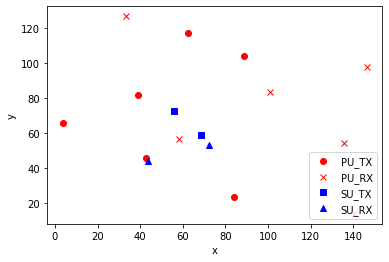

Training time= 2000; success=1252; fail_PU=276; fail_collision=241
Overall reward_1=3.6724
Training time= 4000; success=1252; fail_PU=305; fail_collision=247
Overall reward_1=3.6436
Training time= 6000; success=1301; fail_PU=308; fail_collision=225
Overall reward_1=3.7913
Training time= 8000; success=1304; fail_PU=314; fail_collision=231
Overall reward_1=3.7664
Training time= 10000; success=1257; fail_PU=339; fail_collision=251
Overall reward_1=3.6192
Training time= 12000; success=1263; fail_PU=361; fail_collision=257
Overall reward_1=3.6341
Training time= 14000; success=1288; fail_PU=316; fail_collision=262
Overall reward_1=3.7459
Training time= 16000; success=1295; fail_PU=318; fail_collision=231
Overall reward_1=3.7524
Training time= 18000; success=1272; fail_PU=317; fail_collision=253
Overall reward_1=3.6956
Training time= 20000; success=1278; fail_PU=304; fail_collision=261
Overall reward_1=3.7054
Training time= 22000; success=1272; fail_PU=331; fail_collision=253
Overall reward_1

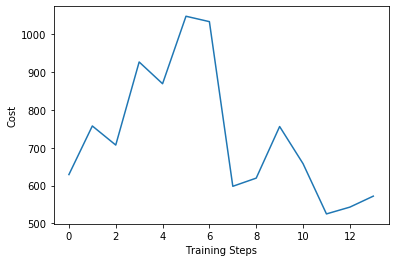

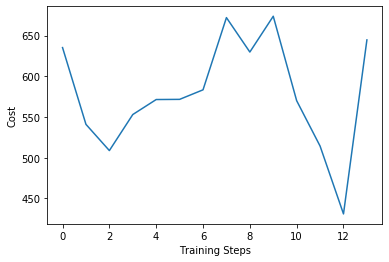

Training time= 30000; success=1330; fail_PU=238; fail_collision=271
Overall reward_1=3.9537
Training time= 32000; success=1309; fail_PU=235; fail_collision=285
Overall reward_1=3.8985
Training time= 34000; success=1319; fail_PU=253; fail_collision=287
Overall reward_1=3.8921
Training time= 36000; success=1329; fail_PU=263; fail_collision=253
Overall reward_1=3.9247
Training time= 38000; success=1330; fail_PU=245; fail_collision=246
Overall reward_1=3.9350
epsilon update to 0.9
Training time= 40000; success=1390; fail_PU=206; fail_collision=218
Overall reward_1=4.1791
Training time= 42000; success=1747; fail_PU=120; fail_collision=92
Overall reward_1=5.3809
Training time= 44000; success=1798; fail_PU=114; fail_collision=56
Overall reward_1=5.5553
Training time= 46000; success=1792; fail_PU=127; fail_collision=55
Overall reward_1=5.5048
Training time= 48000; success=1801; fail_PU=122; fail_collision=54
Overall reward_1=5.5366
Training time= 50000; success=1790; fail_PU=131; fail_collisio

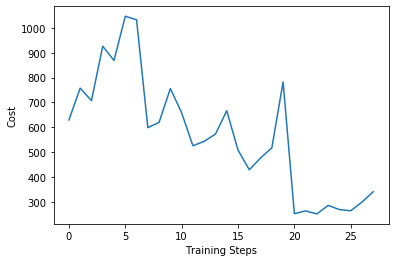

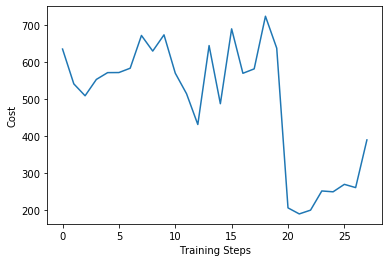

Training time= 58000; success=1802; fail_PU=122; fail_collision=46
Overall reward_1=5.5312
Training time= 60000; success=1798; fail_PU=102; fail_collision=65
Overall reward_1=5.5539
Training time= 62000; success=1809; fail_PU=116; fail_collision=53
Overall reward_1=5.5697
Training time= 64000; success=1799; fail_PU=122; fail_collision=50
Overall reward_1=5.5395
Training time= 66000; success=1818; fail_PU=103; fail_collision=53
Overall reward_1=5.5993
Training time= 68000; success=1796; fail_PU=124; fail_collision=52
Overall reward_1=5.5370
Training time= 70000; success=1788; fail_PU=136; fail_collision=50
Overall reward_1=5.4980
Training time= 72000; success=1791; fail_PU=127; fail_collision=49
Overall reward_1=5.5033
Training time= 74000; success=1809; fail_PU=106; fail_collision=61
Overall reward_1=5.5670
Training time= 76000; success=1785; fail_PU=122; fail_collision=62
Overall reward_1=5.5086
Training time= 78000; success=1807; fail_PU=111; fail_collision=57
Overall reward_1=5.5821

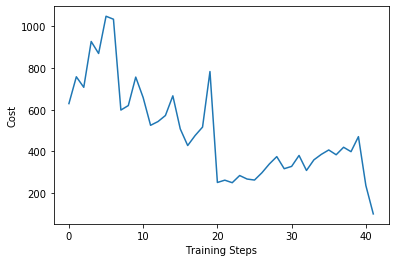

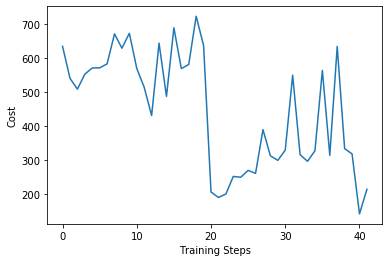

Training time= 86000; success=1903; fail_PU=97; fail_collision=0
Overall reward_1=5.8967
Training time= 88000; success=1900; fail_PU=99; fail_collision=0
Overall reward_1=5.8964
Training time= 90000; success=1904; fail_PU=96; fail_collision=0
Overall reward_1=5.8723
Training time= 92000; success=1895; fail_PU=104; fail_collision=0
Overall reward_1=5.8515
Training time= 94000; success=1899; fail_PU=101; fail_collision=0
Overall reward_1=5.8449
Training time= 96000; success=1908; fail_PU=92; fail_collision=0
Overall reward_1=5.8713
Training time= 98000; success=1892; fail_PU=108; fail_collision=0
Overall reward_1=5.8449
Training time= 100000; success=1891; fail_PU=109; fail_collision=0
Overall reward_1=5.8304
Training time= 102000; success=1909; fail_PU=90; fail_collision=0
Overall reward_1=5.9108
Training time= 104000; success=1895; fail_PU=104; fail_collision=0
Overall reward_1=5.8519
Training time= 106000; success=1893; fail_PU=107; fail_collision=0
Overall reward_1=5.8522
Training ti

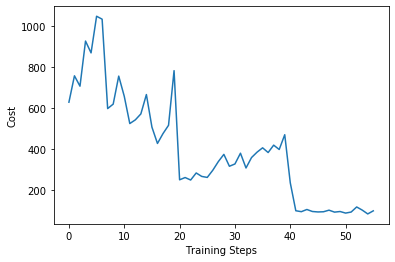

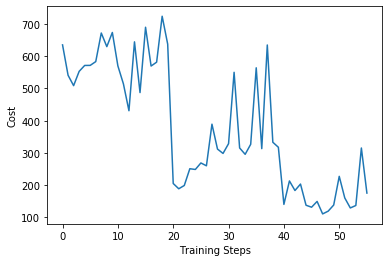

Training time= 114000; success=1908; fail_PU=92; fail_collision=0
Overall reward_1=5.9104
Training time= 116000; success=1911; fail_PU=88; fail_collision=0
Overall reward_1=5.9289
Training time= 118000; success=1897; fail_PU=102; fail_collision=0
Overall reward_1=5.8744
epsilon update to 1.0
Training time= 120000; success=1904; fail_PU=96; fail_collision=0
Overall reward_1=5.8841
Training time= 122000; success=1904; fail_PU=96; fail_collision=0
Overall reward_1=5.9015
Training time= 124000; success=1895; fail_PU=105; fail_collision=0
Overall reward_1=5.8637
Training time= 126000; success=1902; fail_PU=98; fail_collision=0
Overall reward_1=5.8795
Training time= 128000; success=1901; fail_PU=99; fail_collision=0
Overall reward_1=5.8733
Training time= 130000; success=1896; fail_PU=104; fail_collision=0
Overall reward_1=5.8613
Training time= 132000; success=1898; fail_PU=102; fail_collision=0
Overall reward_1=5.8536
Training time= 134000; success=1895; fail_PU=104; fail_collision=0
Overall

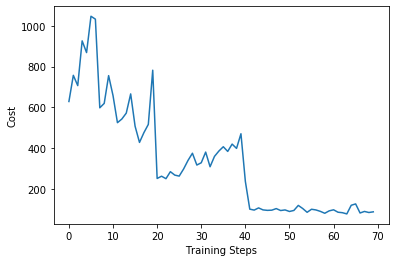

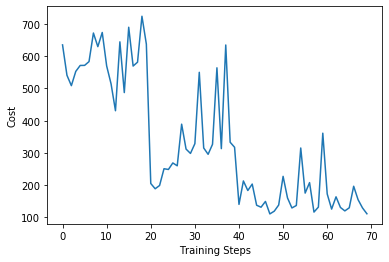

Training time= 142000; success=1897; fail_PU=102; fail_collision=0
Overall reward_1=5.8417
Training time= 144000; success=1894; fail_PU=106; fail_collision=0
Overall reward_1=5.8312
Training time= 146000; success=1896; fail_PU=103; fail_collision=0
Overall reward_1=5.8377
Training time= 148000; success=1895; fail_PU=104; fail_collision=0
Overall reward_1=5.8636
Training time= 150000; success=1898; fail_PU=101; fail_collision=0
Overall reward_1=5.8514
Training time= 152000; success=1902; fail_PU=97; fail_collision=0
Overall reward_1=5.8881
Training time= 154000; success=1897; fail_PU=102; fail_collision=0
Overall reward_1=5.8676
Training time= 156000; success=1898; fail_PU=102; fail_collision=0
Overall reward_1=5.8682
Training time= 158000; success=1889; fail_PU=110; fail_collision=0
Overall reward_1=5.8260
epsilon update to 1.0
Training time= 160000; success=1896; fail_PU=103; fail_collision=0
Overall reward_1=5.8632
Training time= 162000; success=1895; fail_PU=104; fail_collision=0
Ov

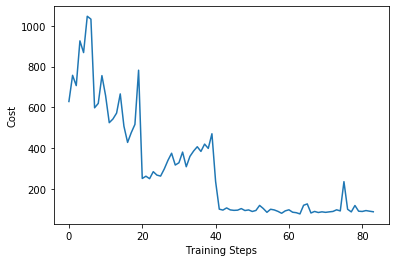

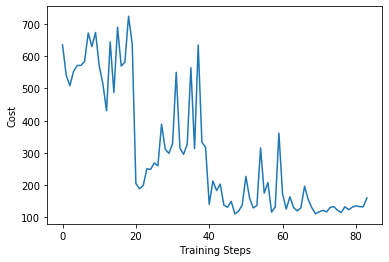

Training time= 170000; success=1896; fail_PU=103; fail_collision=0
Overall reward_1=5.8646
Training time= 172000; success=1899; fail_PU=101; fail_collision=0
Overall reward_1=5.8608
Training time= 174000; success=1897; fail_PU=103; fail_collision=0
Overall reward_1=5.8613
Training time= 176000; success=1887; fail_PU=113; fail_collision=0
Overall reward_1=5.8288
Training time= 178000; success=1904; fail_PU=95; fail_collision=0
Overall reward_1=5.8765
Training time= 180000; success=1892; fail_PU=108; fail_collision=0
Overall reward_1=5.8497
Training time= 182000; success=1892; fail_PU=108; fail_collision=0
Overall reward_1=5.8404
Training time= 184000; success=1893; fail_PU=107; fail_collision=0
Overall reward_1=5.8432
Training time= 186000; success=1912; fail_PU=87; fail_collision=0
Overall reward_1=5.9242
Training time= 188000; success=1896; fail_PU=104; fail_collision=0
Overall reward_1=5.8490
Training time= 190000; success=1889; fail_PU=110; fail_collision=0
Overall reward_1=5.8278
T

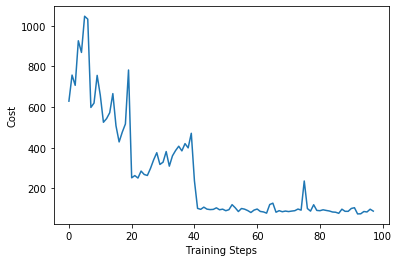

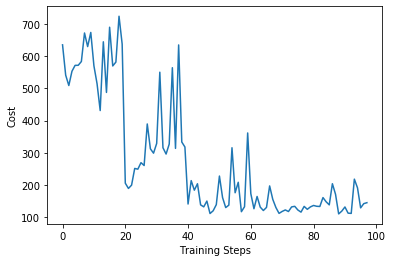

Training time= 198000; success=1892; fail_PU=107; fail_collision=0
Overall reward_1=5.8244
epsilon update to 1.0
Training time= 200000; success=1901; fail_PU=99; fail_collision=0
Overall reward_1=5.8560
Training time= 202000; success=1911; fail_PU=89; fail_collision=0
Overall reward_1=5.9130
Training time= 204000; success=1900; fail_PU=99; fail_collision=0
Overall reward_1=5.8804
Training time= 206000; success=1913; fail_PU=87; fail_collision=0
Overall reward_1=5.9381
Training time= 208000; success=1908; fail_PU=92; fail_collision=0
Overall reward_1=5.9260
Training time= 210000; success=1894; fail_PU=105; fail_collision=0
Overall reward_1=5.8593
Training time= 212000; success=1895; fail_PU=104; fail_collision=0
Overall reward_1=5.8503
Training time= 214000; success=1903; fail_PU=97; fail_collision=0
Overall reward_1=5.8821
Training time= 216000; success=1896; fail_PU=104; fail_collision=0
Overall reward_1=5.8729
Training time= 218000; success=1885; fail_PU=115; fail_collision=0
Overall

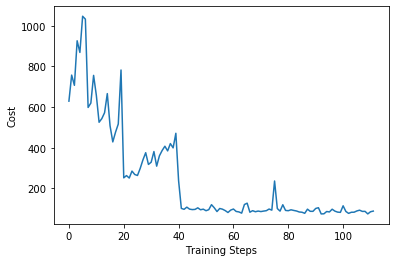

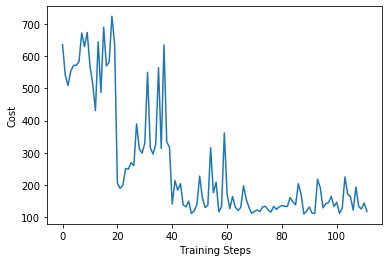

Training time= 226000; success=1907; fail_PU=92; fail_collision=0
Overall reward_1=5.8895
Training time= 228000; success=1899; fail_PU=101; fail_collision=0
Overall reward_1=5.8722
Training time= 230000; success=1896; fail_PU=103; fail_collision=0
Overall reward_1=5.8498
Training time= 232000; success=1894; fail_PU=106; fail_collision=0
Overall reward_1=5.8456
Training time= 234000; success=1897; fail_PU=103; fail_collision=0
Overall reward_1=5.8423
Training time= 236000; success=1894; fail_PU=105; fail_collision=0
Overall reward_1=5.8709
Training time= 238000; success=1904; fail_PU=96; fail_collision=0
Overall reward_1=5.8562
epsilon update to 1.0
Training time= 240000; success=1897; fail_PU=102; fail_collision=0
Overall reward_1=5.8701
Training time= 242000; success=1896; fail_PU=104; fail_collision=0
Overall reward_1=5.8331
Training time= 244000; success=1905; fail_PU=95; fail_collision=0
Overall reward_1=5.8881
Training time= 246000; success=1902; fail_PU=98; fail_collision=0
Overa

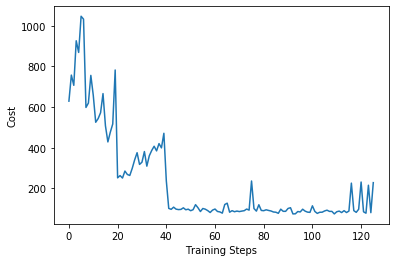

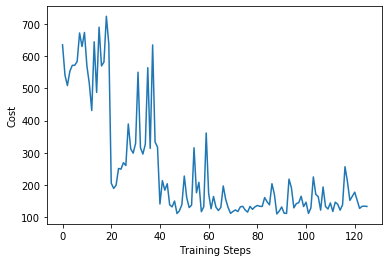

Training time= 254000; success=1888; fail_PU=111; fail_collision=0
Overall reward_1=5.8356
Training time= 256000; success=1893; fail_PU=107; fail_collision=0
Overall reward_1=5.8564
Training time= 258000; success=1911; fail_PU=89; fail_collision=0
Overall reward_1=5.9176
Training time= 260000; success=1893; fail_PU=106; fail_collision=0
Overall reward_1=5.8701
Training time= 262000; success=1902; fail_PU=98; fail_collision=0
Overall reward_1=5.8965
Training time= 264000; success=1907; fail_PU=93; fail_collision=0
Overall reward_1=5.9031
Training time= 266000; success=1892; fail_PU=107; fail_collision=0
Overall reward_1=5.8389
Training time= 268000; success=1897; fail_PU=103; fail_collision=0
Overall reward_1=5.8758
Training time= 270000; success=1903; fail_PU=96; fail_collision=0
Overall reward_1=5.8968
Training time= 272000; success=1905; fail_PU=94; fail_collision=0
Overall reward_1=5.8922
Training time= 274000; success=1887; fail_PU=113; fail_collision=0
Overall reward_1=5.8293
Trai

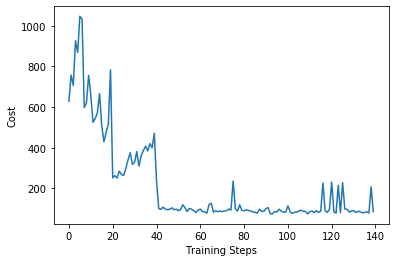

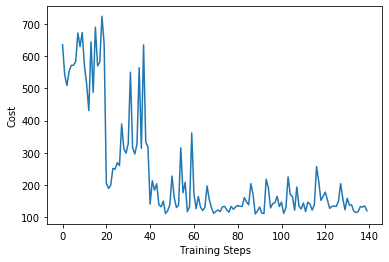

In [71]:
# Running the algorithm and storing result for DQN_RC
if __name__=="__main__":
    random_seed= 3
    np.random.seed(random_seed)
    
    # Initialize the environment
    n_channel=6
    n_su=2
    env=DSA_Markov(n_channel, n_su)
    env_copy= copy.deepcopy(env)
    
    # Training parameters
    if n_channel==6:
        batch_size=2000
    elif n_channel==16:
        batch_size=3000
    elif n_channel==22:
        batch_size=4000
    
    replace_target_iter=1
    total_episode= batch_size*replace_target_iter*140
    epsilon_update_period= batch_size*replace_target_iter*20
    e_greedy= [0.3, 0.9, 1]
    learning_rate=0.01
    
    
    flag_DQN_RC= True
    #flag_Myopic= True
    
    
    
    '''Proposed: DQN_RC'''
    if flag_DQN_RC:
        # Initialize the DQN_RC
        DQN_RC_list=[]
        epsilon_index= np.zeros(n_su, dtype=int)
        for k in range(n_su):
            DQN_tmp= DeepQNetwork(env.n_actions, 
                                  env.n_features, 
                                 reward_decay=0.9, 
                                 e_greedy= e_greedy[0],
                                  replace_target_iter= replace_target_iter,
                                  memory_size=batch_size,
                                  lr=learning_rate
                                 )
            DQN_RC_list.append(DQN_tmp)
            
        # SUs sense the environment and get the sensing result (may contain errors)
        observation= env.sense()
            
         # Initialize some record values
        reward_sum= np.zeros(n_su)
        overall_reward_1= []
        success_hist_1=[]
        fail_PU_hist_1=[]
        fail_collision_hist_1=[]
        success_sum=0
        fail_PU_sum=0
        fail_collision_sum=0
            
            
        action= np.zeros(n_su).astype(np.int32)
        for step in range(total_episode):
            # SU choose action based on observation
            for k in range(n_su):
                action[k]= DQN_RC_list[k].choose_action(observation[k, :])

            # Update the channel states
            env.render()
            env.render_SINR()

            # SU take action and obtain reward
            reward= env.access(action)

            # Record the reward gained
            reward_sum= reward_sum+reward
            # Record the number of successful transmission
            success_sum= success_sum+env.success
            # Record the number of collsions with PU
            fail_PU_sum=fail_PU_sum+ env.fail_PU
            # Record the number of collsions with SU
            fail_collision_sum= fail_collision_sum+ env.fail_collision

            # SU sense the environment and get sensing result(may contain error)
            observation_= env.sense()

            # Store one episode (s, a, r, s_)
            for k in range(n_su):
                state= observation[k, :]
                state_= observation_[k, :]
                DQN_RC_list[k].store_transition(state, action[k], reward[k], state_)

            # Each SU learns their DQN model
            if ((step+1)%batch_size==0):
                for k in range(n_su):
                    DQN_RC_list[k].learn()

                # Record reward, number of success/interference/collision
                overall_reward_1.append(np.sum(reward_sum)/batch_size/n_su)
                success_hist_1.append(success_sum/n_su)
                fail_PU_hist_1.append(fail_PU_sum/n_su)
                fail_collision_hist_1.append(fail_collision_sum/n_su)


                # After one batch, refresh the record
                reward_sum=0
                success_sum=0
                fail_PU_sum=0
                fail_collision_sum=0

            # Update epsilon
            if ((step+1)% epsilon_update_period==0):
                for k in range(n_su):
                    epsilon_index[k]= min(len(e_greedy)-1, epsilon_index[k]+1)
                    DQN_RC_list[k].epsilon= e_greedy[epsilon_index[k]]
                print("epsilon update to %.1f"%(DQN_RC_list[k].epsilon))

            # Print the record after replacing DQN_target
            if ((step+1)%(batch_size*replace_target_iter)==0):
                print("Training time= %d; success=%d; fail_PU=%d; fail_collision=%d"%
                     ((step+1), success_hist_1[-1], fail_PU_hist_1[-1], fail_collision_hist_1[-1]))
                print("Overall reward_1=%.4f"%overall_reward_1[-1])
                
            # Plot cost function
            if ((step+1)%28000==0):
                for k in range(n_su):
                    DQN_RC_list[k].plot_cost()

            #Swap observation
            observation= observation_

In [72]:
overall_reward_1=np.array(overall_reward_1)
success_hist_1= np.array(success_hist_1)
fail_PU_hist_1= np.array(fail_PU_hist_1)
fail_collision_hist_1= np.array(fail_collision_hist_1)
type(overall_reward_1)
rec_num=int(140/4)
rec_num


o_mean_1=np.zeros((rec_num))
success_mean_1=np.zeros((rec_num))
fail_PU_mean_1=np.zeros((rec_num))
fail_collision_mean_1=np.zeros((rec_num))
for k in range(rec_num):
    index=np.arange(k*4, (k+1)*4)
    #print(index)
    o_mean_1[k]= np.mean(overall_reward_1[index])
    success_mean_1[k]= np.mean(success_hist_1[index])
    fail_PU_mean_1[k]= np.mean(fail_PU_hist_1[index])
    fail_collision_mean_1[k]= np.mean(fail_collision_hist_1[index])
    #print(0_mean)

#o_mean=np.array(o_mean)    
total_rec_num=(np.arange(rec_num)+1)*batch_size*4
#print((o_mean).shape)
print((total_rec_num).shape)

(35,)


In [73]:
overall_reward_4=np.array(overall_reward_4)
success_hist_4= np.array(success_hist_4)
fail_PU_hist_4= np.array(fail_PU_hist_4)
fail_collision_hist_4= np.array(fail_collision_hist_4)
type(overall_reward_4)
rec_num=int(140/4)
rec_num


o_mean_4=np.zeros((rec_num))
success_mean_4=np.zeros((rec_num))
fail_PU_mean_4=np.zeros((rec_num))
fail_collision_mean_4=np.zeros((rec_num))
for k in range(rec_num):
    index=np.arange(k*4, (k+1)*4)
    #print(index)
    o_mean_4[k]= np.mean(overall_reward_4[index])
    success_mean_4[k]= np.mean(success_hist_4[index])
    fail_PU_mean_4[k]= np.mean(fail_PU_hist_4[index])
    fail_collision_mean_4[k]= np.mean(fail_collision_hist_4[index])
    #print(0_mean)

#o_mean=np.array(o_mean)    
total_rec_num=(np.arange(rec_num)+1)*batch_size*4
#print((o_mean).shape)
print((total_rec_num).shape)

(35,)


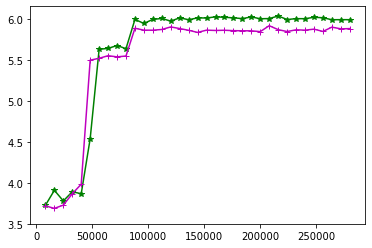

In [74]:
# Figure for overall reward for both cases: green(DQN_MLP), magenta: DQN_RC
plt.figure()
plt.plot(total_rec_num, o_mean_4,'g-*')
plt.plot(total_rec_num, o_mean_1,'m-+')
plt.ylim(3.5,6.15)
plt.show()

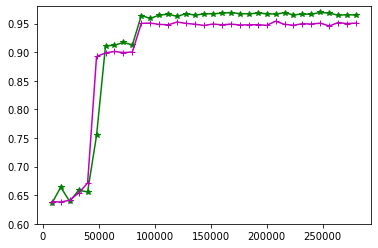

In [77]:
# Figure for success rate for both cases: green(DQN_MLP), magenta: DQN_RC
plt.figure()
plt.plot(total_rec_num, success_mean_4/batch_size,'g-*')
plt.plot(total_rec_num, success_mean_1/batch_size,'m-+')
plt.ylim(0.6,0.98)
plt.show()

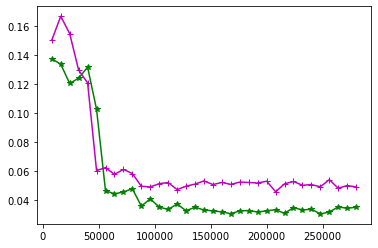

In [78]:
# Figure for collision with PU for both cases: green(DQN_MLP), magenta: DQN_RC
plt.figure()
plt.plot(total_rec_num, fail_PU_mean_4/batch_size,'g-*')
plt.plot(total_rec_num, fail_PU_mean_1/batch_size,'m-+')
#plt.ylim(0, 0.175)
plt.show()

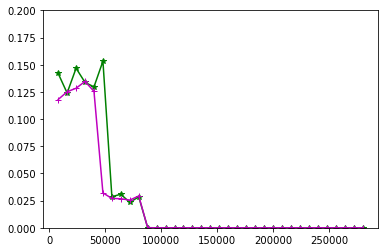

In [79]:
# Figure for collision with SU green(DQN_MLP), magenta: DQN_RC
plt.figure()
plt.plot(total_rec_num, fail_collision_mean_4/batch_size,'g-*')
plt.plot(total_rec_num, fail_collision_mean_1/batch_size,'m-+')
plt.ylim(0,0.2)
plt.show()